## 3. Descriptive Analysis

In this part we would like to get descriptive analysis. The dataset we use are labeled event dataframe from wrangling notebook and ml dataframe with features from feature extraction notebook

### Setup Prerequisite

In [1]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 17.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=873d31397242e7f46d1c42e435747c471d035cad4617b6d65dc839b68bab302d
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Needed Library and Initialiaze PySpark

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.appName("sparkify").getOrCreate()

### Load Dataset from Blob

In [5]:
# load data
isOnColab = True # CHANGE THIS VARIABLE IF RUNNING ON DATAPROC

path = '/content/drive/MyDrive/datasets/dsnd-sparkify/event_labeled.parquet' if isOnColab else 'gs://udacity-dsnd/event_labeled.parquet'
df = spark.read.parquet(path)
path = '/content/drive/MyDrive/datasets/dsnd-sparkify/ml_df.parquet' if isOnColab else 'gs://udacity-dsnd/ml_df.parquet'
ml_df = spark.read.parquet(path)

In [6]:
ml_df.limit(5).toPandas()

,userId,up_ts,is_churn,song_count,subs_duration,song_rate,n_playlist,thumbs_down,thumbs_up,avg_sess_len,sess_count,ipad,iphone,linux,macos,windows,n_error,n_friend_add,n_cancel_page,n_unq_song,n_unq_artist
0,1071843,2018-11-08 13:16:59,False,1190,22,54.090909,39,6,51,27020.272727,11,False,False,False,True,False,1,32,0,1104,902
1,1120784,2018-10-11 14:16:28,False,1502,50,30.040000,45,17,122,14162.807692,26,False,False,False,False,True,2,24,0,1357,1042
2,1128522,2018-11-13 17:46:22,True,203,2,101.500000,9,6,12,17188.666667,3,False,False,False,True,False,0,4,0,198,190
3,1130061,2018-10-11 20:04:50,False,96,50,1.920000,4,4,3,11930.500000,2,False,False,False,True,False,0,2,1,96,92
4,1135039,2018-10-04 11:31:06,False,643,57,11.280702,29,4,49,22156.285714,7,False,False,False,False,True,2,12,0,611,513


### Descriptive Analysis
after load the data into variable, we produce descriptive analytic.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


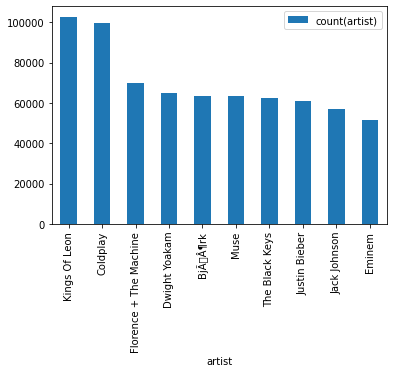

In [7]:
# most popular artist
df.groupby("artist").agg(F.count("artist")).sort(F.col("count(artist)"), ascending=False).limit(10) \
    .toPandas().plot.bar(x="artist", y="count(artist)")

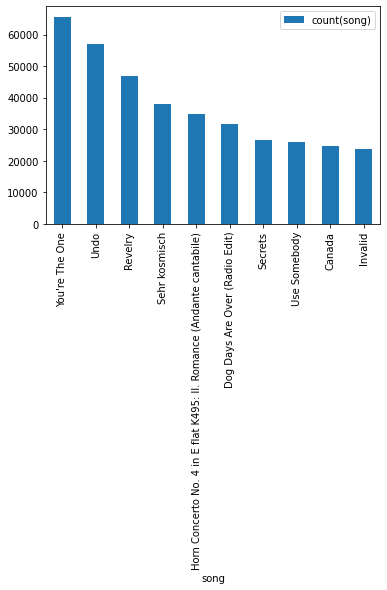

In [8]:
# most played song
df.groupby("song").agg(F.count("song")).sort(F.col("count(song)"), ascending=False).limit(10) \
    .toPandas().plot.bar(x="song", y="count(song)")

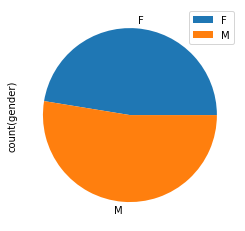

In [9]:
# proportion of gender
df.groupby("gender").agg(F.count("gender")) \
    .toPandas().groupby("gender").sum().plot.pie(y="count(gender)")

In [10]:
#number of user
df.select("userId").distinct().count()

12082

In [11]:
#number of premium user
df.filter(df.page.isin(["Submit Upgrade", "Submit Downgrade"])) \
    .groupby("userId").pivot("page").agg(F.count("page")) \
    .agg(F.count(F.col("Submit Downgrade")), F.count(F.col("Submit Upgrade"))) \
    .show(5)

+-----------------------+---------------------+
|count(Submit Downgrade)|count(Submit Upgrade)|
+-----------------------+---------------------+
|                   3881|                12082|
+-----------------------+---------------------+



In [12]:
# traffic proportion
df.groupby("auth").agg(F.count("auth")).show()

+---------+-----------+
|     auth|count(auth)|
+---------+-----------+
|Cancelled|       2568|
|Logged In|   15151474|
+---------+-----------+



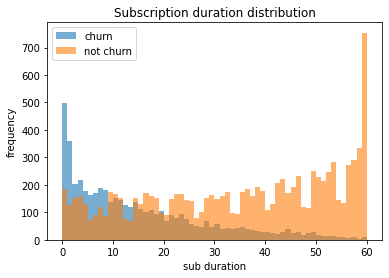

In [13]:
# user subscription duration
churn_pd = ml_df.select(["is_churn", "subs_duration"]).toPandas()

plt.hist(churn_pd['subs_duration'][churn_pd['is_churn'] == True], bins=60, alpha=.6, label='churn')
plt.hist(churn_pd['subs_duration'][churn_pd['is_churn'] == False], bins=60, alpha=.6, label='not churn')
plt.legend()
plt.title("Subscription duration distribution")
plt.xlabel("sub duration")
plt.ylabel("frequency")
plt.show()

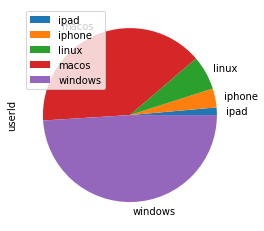

In [23]:
# prportion of used device
device_df = ml_df.select(["userId","ipad", "iphone", "macos", "linux", "windows"]) \
    .toPandas().melt(id_vars=['userId'], var_name="device", value_name="bool")

device_df[device_df['bool']][["device", "userId"]].groupby("device").count() \
    .plot.pie(y="userId")